# Main Simulation Loop Construction

Develop the main simulation loop for the formation model

01/05/2023

Andrew Weng

In [171]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import pandas as pd
import numpy as np
import yaml
from src import cellsim as cellsim 

%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the configuration

In [172]:
with open("params/default.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config

{'R_n': 2e-05,
 'L_n': 8e-05,
 'A_n': 0.1,
 'epsilon_n': 0.7,
 'a_sn': 105000,
 'alpha_SEI': 0.5,
 'delta_SEI_0': 5e-09,
 'SEI1_name': 'Li2EDC',
 'c_SEI1_0': 4541,
 'V_SEI1': 9.585e-05,
 'k_SEI1': 1e-11,
 'D_SEI1': 2e-16,
 'U_SEI1': 0.8,
 'SEI2_name': 'LiMC',
 'c_SEI2_0': 4541,
 'V_SEI2': 5.81e-05,
 'k_SEI2': 1e-11,
 'D_SEI2': 2e-17,
 'U_SEI2': 0.3,
 'c0': 15,
 'c1': 0.00166667,
 'c2': 0.00166667,
 'R0p': 0.0205,
 'R0n': 0.0205,
 'R1p': 0.079,
 'R1n': 0.079,
 'C1p': 76000,
 'C1n': 76000,
 'Cn': 6,
 'Cp': 6,
 'theta_n': 0.0,
 'theta_p': 1.0}

In [173]:
%autoreload

chg_current_amps = +0.5
dch_current_amps = -0.5
current_cv_cut_amps = 0.5 / 20
sim_time_s = 150*3600

cell = cellsim.Cell(config)
sim = cellsim.Simulation(cell, sim_time_s)

In [174]:
mode = 'cc_charge'
cycle_number = 1

print(f'Simulating Cycle {cycle_number}...')

for k in range(0, len(sim.t) - 1):

    # Initial rest step
    if sim.t[k] < 10*3600:
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue

    # Final rest step
    if cycle_number > 3:
        sim.step(k, 'cc', icc=0, cyc_num=cycle_number,
                 step_num=3) 
        continue

    elif mode == 'cc_charge':

        sim.step(k, 'cc', icc=chg_current_amps, cyc_num=cycle_number,
                 step_num=0) 

        # Check for constant voltage condition
        if sim.vt[k+1] >= sim.vmax:
            print('Switching from CC charge to CV charge...')
            mode = 'cv_charge'
            sim.vt[k+1] = sim.vmax
            continue
        
    elif mode == 'cv_charge':

        sim.step(k, 'cv', 
                 icv=current_cv_cut_amps, 
                 cyc_num=cycle_number,
                 step_num=1)

        if np.abs( sim.i_app[k] ) < np.abs( current_cv_cut_amps ):
            print('Switching from CV charge to CC discharge...')
            mode = 'cc_discharge'
            continue

    elif mode == 'cc_discharge':

        sim.step(k, 'cc', 
                 icc=dch_current_amps, 
                 cyc_num=cycle_number,
                 step_num=2)
        
        if sim.vt[k+1] <= sim.vmin: 
           mode = 'cc_charge'
           cycle_number += 1
           print(f'Simulating Cycle {cycle_number}...')
           continue

print('Done.')


Simulating Cycle 1...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 2...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 3...
Switching from CC charge to CV charge...
Switching from CV charge to CC discharge...
Simulating Cycle 4...
Done.


# Make the plot

/Users/aweng/code/formation-modeling/src/cellsim.py:348: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('outputs/figures/fig_formation_simulation.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


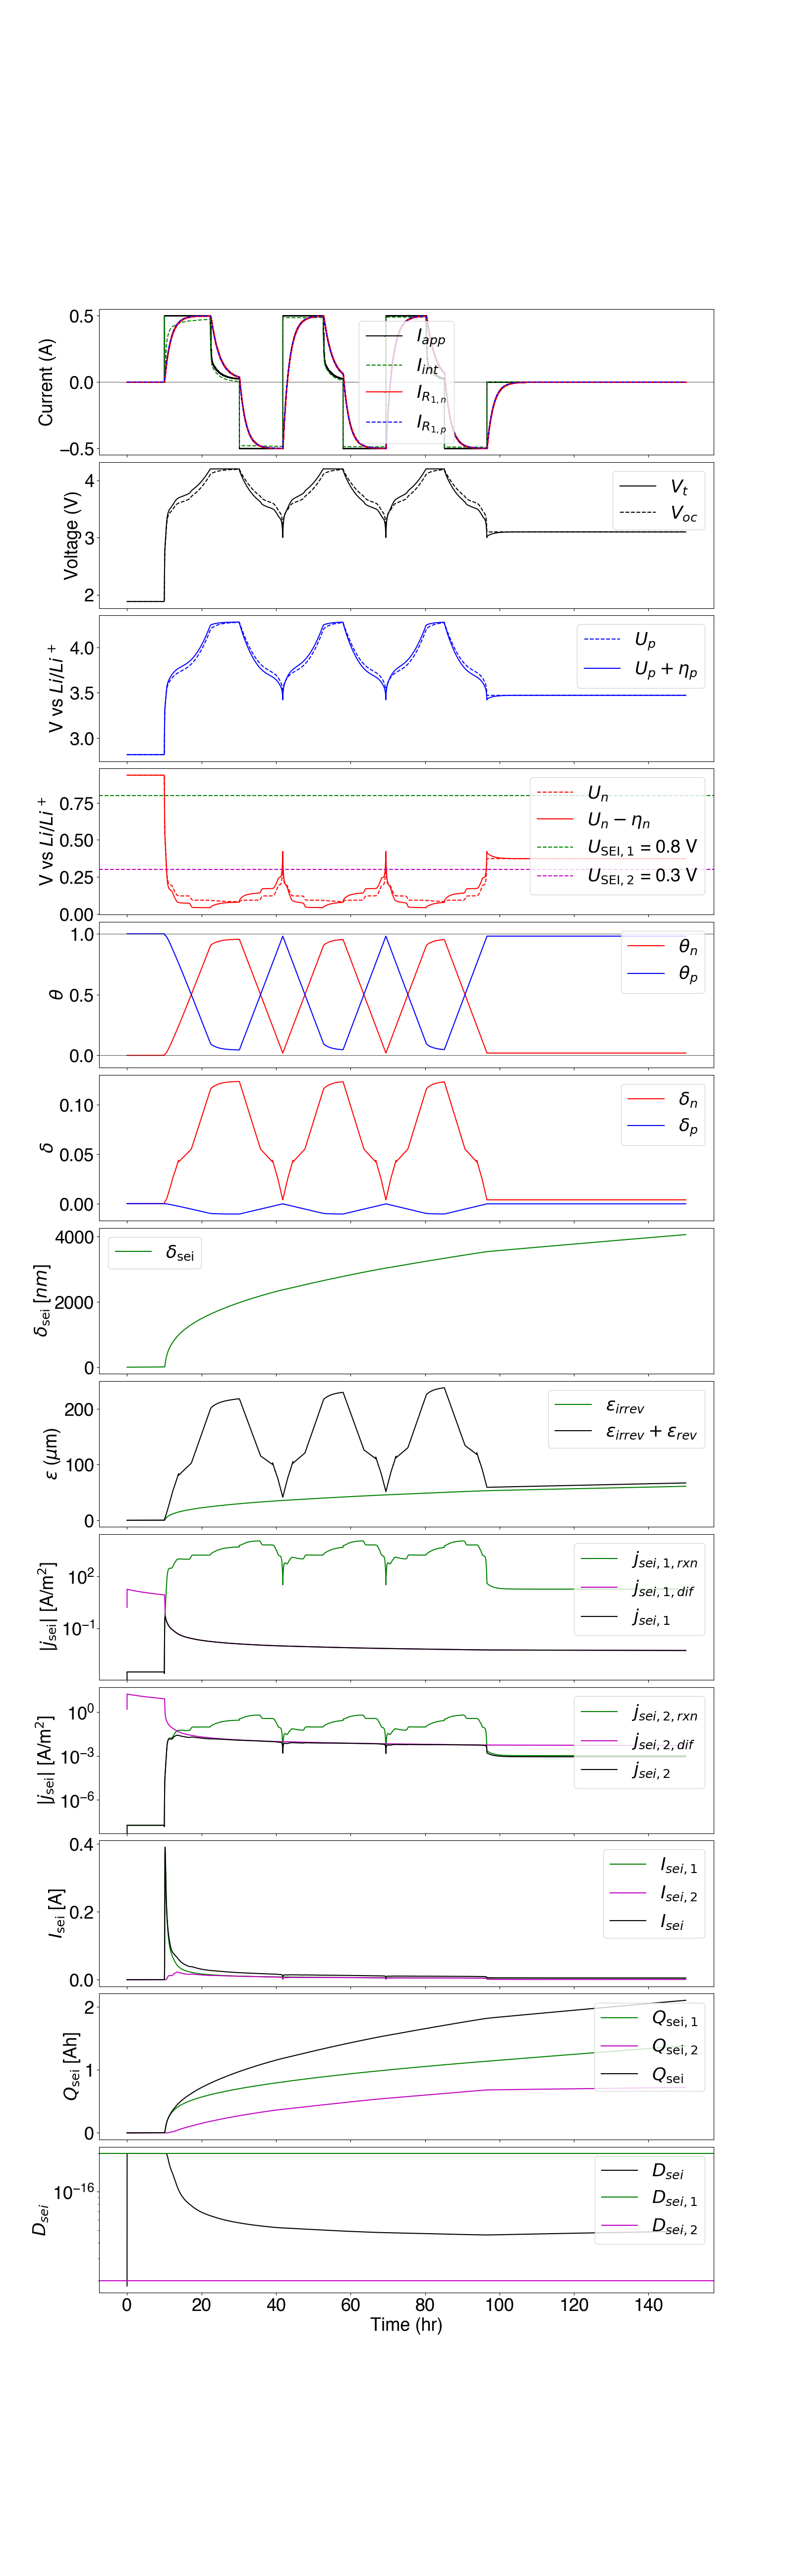

In [175]:
%autoreload
sim.plot()

In [176]:
df = pd.DataFrame(sim.__dict__)
df

,cell,dt,t,vmax,vmin,i_cv,i_app,cycle_number,step_number,theta_n,...,j_sei_rxn2,j_sei_dif1,j_sei_dif2,eta_sei1,eta_sei2,delta_sei,delta_n,delta_p,expansion_rev,expansion_irrev
0,<src.cellsim.Cell object at 0x125f894c0>,1.0,0.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,5.000000e-09,0.000000,-0.000000,0.000000,0.000000e+00
1,<src.cellsim.Cell object at 0x125f894c0>,1.0,1.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000,...,1.827339e-08,1.593236,1.593236,0.136495,0.636495,5.000153e-09,0.000000,-0.000000,0.000000,7.500229e-08
2,<src.cellsim.Cell object at 0x125f894c0>,1.0,2.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000,...,1.827339e-08,17.515693,17.515693,0.136495,0.636495,5.000306e-09,0.000000,-0.000000,0.000000,7.500458e-08
3,<src.cellsim.Cell object at 0x125f894c0>,1.0,3.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000,...,1.827339e-08,17.515159,17.515159,0.136495,0.636495,5.000458e-09,0.000000,-0.000000,0.000000,7.500687e-08
4,<src.cellsim.Cell object at 0x125f894c0>,1.0,4.0,4.2,3.0,0.025,0.0,1.0,3.0,0.000000,...,1.827339e-08,17.514624,17.514624,0.136495,0.636495,5.000611e-09,0.000000,-0.000000,0.000000,7.500917e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539995,<src.cellsim.Cell object at 0x125f894c0>,1.0,539995.0,4.2,3.0,0.025,0.0,4.0,3.0,0.019021,...,1.068122e-03,0.005276,0.005276,-0.427476,0.072524,4.062000e-06,0.003804,-0.000209,0.000006,6.093000e-05
539996,<src.cellsim.Cell object at 0x125f894c0>,1.0,539996.0,4.2,3.0,0.025,0.0,4.0,3.0,0.019021,...,1.068122e-03,0.005276,0.005276,-0.427476,0.072524,4.062003e-06,0.003804,-0.000209,0.000006,6.093004e-05
539997,<src.cellsim.Cell object at 0x125f894c0>,1.0,539997.0,4.2,3.0,0.025,0.0,4.0,3.0,0.019021,...,1.068122e-03,0.005276,0.005276,-0.427476,0.072524,4.062005e-06,0.003804,-0.000209,0.000006,6.093008e-05
539998,<src.cellsim.Cell object at 0x125f894c0>,1.0,539998.0,4.2,3.0,0.025,0.0,4.0,3.0,0.019021,...,1.068122e-03,0.005276,0.005276,-0.427476,0.072524,4.062008e-06,0.003804,-0.000209,0.000006,6.093012e-05


# Calculate cycle-by-cycle metrics

In [177]:
df = pd.DataFrame(sim.__dict__)
df['dq'] = np.abs(df['dt'] * df['i_app'] / 3600)
df_agg = df.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
df_agg

cycle_number  step_number
0.0           0.0            0.000000
1.0           0.0            6.170139
              1.0            0.533772
              2.0            5.827083
              3.0            0.000000
2.0           0.0            5.423056
              1.0            0.405207
              2.0            5.744722
3.0           0.0            5.384861
              1.0            0.381456
              2.0            5.713750
4.0           3.0            0.000000
Name: dq, dtype: float64

/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.manager.handle_json(content)


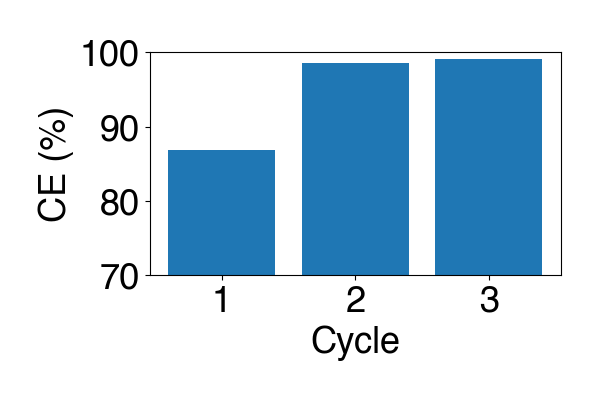

In [178]:
from matplotlib import pyplot as plt

ce = []
cycle_index = np.array([1, 2, 3])

for i in cycle_index:
    ce.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))

ce = np.array(ce)

plt.figure(figsize=(6, 4))
plt.bar(cycle_index, ce*100)
plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.ylim([70, 100])
plt.show()
